# Data format example

In [1]:
import pypesto
import amici
import petab

import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

## Manage PETAB model

In [2]:
folder_base = "/home/yannik/benchmark-models/hackathon_contributions_new_data_format/"
model_name = "Zheng_PNAS2012"

manager = petab.Manager.from_folder(folder_base + model_name)

# print(petab.lint.check_measurement_df(manager.measurement_df))
manager.get_optimization_to_simulation_parameter_mapping()


[['inflowp',
  'k00_01',
  'k00_10',
  'k01_00',
  'k01_02',
  'k01_11',
  'k02_01',
  'k02_03',
  'k02_12',
  'k03_02',
  'k03_13',
  'k10_00',
  'k10_11',
  'k10_20',
  'k11_01',
  'k11_10',
  'k11_12',
  'k11_21',
  'k12_02',
  'k12_11',
  'k12_13',
  'k12_22',
  'k13_03',
  'k13_12',
  'k13_23',
  'k20_10',
  'k20_21',
  'k20_30',
  'k21_11',
  'k21_20',
  'k21_22',
  'k21_31',
  'k22_12',
  'k22_21',
  'k22_23',
  'k22_32',
  'k23_13',
  'k23_22',
  'k30_20',
  'k30_31',
  'k31_21',
  'k31_30',
  'k31_32',
  'k32_22',
  'k32_31',
  'sigma',
  'sigma',
  'sigma',
  'sigma',
  'sigma',
  'sigma',
  'sigma',
  'sigma',
  'sigma',
  'sigma',
  'sigma',
  'sigma',
  'sigma',
  'sigma',
  'sigma']]

## Import model to AMICI

In [3]:
importer = pypesto.objective.Importer(manager)

model = importer.model
print(model.getParameterScale())
print("Model parameters:", list(model.getParameterIds()), '\n')
print("Model const parameters:", list(model.getFixedParameterIds()), '\n')
print("Model outputs:   ", list(model.getObservableIds()), '\n')
print("Model states:    ", list(model.getStateIds()), '\n')

<amici.amici.ParameterScalingVector; proxy of <Swig Object of type 'std::vector< enum amici::ParameterScaling,std::allocator< enum amici::ParameterScaling > > *' at 0x7f5744732150> >
Model parameters: ['inflowp', 'k00_01', 'k00_10', 'k01_00', 'k01_02', 'k01_11', 'k02_01', 'k02_03', 'k02_12', 'k03_02', 'k03_13', 'k10_00', 'k10_11', 'k10_20', 'k11_01', 'k11_10', 'k11_12', 'k11_21', 'k12_02', 'k12_11', 'k12_13', 'k12_22', 'k13_03', 'k13_12', 'k13_23', 'k20_10', 'k20_21', 'k20_30', 'k21_11', 'k21_20', 'k21_22', 'k21_31', 'k22_12', 'k22_21', 'k22_23', 'k22_32', 'k23_13', 'k23_22', 'k30_20', 'k30_31', 'k31_21', 'k31_30', 'k31_32', 'k32_22', 'k32_31', 'noiseParameter1_K27me0K36me0', 'noiseParameter1_K27me0K36me1', 'noiseParameter1_K27me0K36me2', 'noiseParameter1_K27me0K36me3', 'noiseParameter1_K27me1K36me0', 'noiseParameter1_K27me1K36me1', 'noiseParameter1_K27me1K36me2', 'noiseParameter1_K27me1K36me3', 'noiseParameter1_K27me2K36me0', 'noiseParameter1_K27me2K36me1', 'noiseParameter1_K27me2K36m

## Create objective function

In [4]:
obj, edatas = importer.create_objective()

#print(amici.getDataObservablesAsDataFrame(obj.amici_model, edatas))
#print(edatas[0].fixedParametersPreequilibration)
#print(obj.dim, obj.x_names, len(obj.x_ids), obj.opt_to_sim_par_mapping)
#print(edatas[0].fixedParametersPreequilibration, edatas[0].fixedParameters)

print("Nominal parameter values:\n", manager.x_nominal)

obj(manager.x_nominal)

Nominal parameter values:
 [-1.5159682952674898, 2.9988193951672297, -0.630741725766828, 2.68109795960193, 0.28180198273587803, 0.42349081778982295, -1.1551277123136001, -4.9999998124438605, -4.99999947455282, -4.9999999999999805, 2.99481075522779, -4.99999999992626, -4.9999999896302, -0.569938364856428, -4.999999999992509, -4.99987145176529, 1.07378392980943, -4.99999998476407, -4.999999999999151, -0.9706187453753949, -1.4481854451767502, -1.9740149272557699, 2.65363298331167, -0.7093963282018, -4.99999999809633, -4.9999999999999805, -4.99999981237195, -0.821771073094981, -4.99984610213653, -1.4510243457070202, 2.99968703404029, -4.999999998862441, -1.2726243778748798, 2.6295555324501003, -0.81889591101979, -4.9999999999999805, -0.10171307017624699, -4.9999967086855595, -4.9999994008315305, -0.5508265129504879, -4.99962003467971, -4.999989572738009, -0.45144917629559794, -0.198608740210104, -4.9999999999999805, -2.6308831038901697]


-278.3335326998418

## Run optimization

In [5]:
optimizer = pypesto.ScipyOptimizer()

problem = importer.create_problem(obj)

# do the optimization
result = pypesto.minimize(problem=problem, optimizer=optimizer,
                          n_starts=10)

## Visualize

[89.73546023792342, 197.65353775027867, 12744.829906768144, 65838.72848584365, 162993.0822604314, 403629.6615747656, 704472.3931813606, 56122247.213399224, 697108149.2958972, 24388101824.49773]


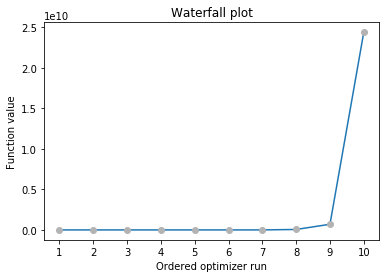

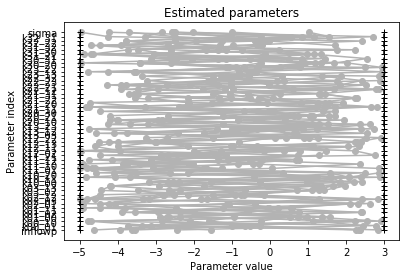

In [6]:
import pypesto.visualize

pypesto.visualize.waterfall(result)
pypesto.visualize.parameters(result)

print(result.optimize_result.get_for_key('fval'))

In [7]:
df = obj.simulations_to_measurement_df(result.optimize_result.get_for_key('x')[0])
plt.xlabel("Experiment")
plt.ylabel("Simulation")
plt.scatter(importer.measurement_df['measurement'], df['measurement'])

RuntimeError: Dimension mismatch. Size of parameters does not match number of model parameters.

In [ ]:
edatas_sim = obj.simulate(x_bst)
df_sim = importer.to_measurement_df(edatas_sim)
plot_simulation(manager.measurement_df, [df_sim])